# Project 03: Retinal Diabetic Retinopathy — Scope & Data

## 🎯 Concept Primer
Multi-class image classification: Classify retinal images by DR severity (0-4).

**Labels:** 0=No DR, 1=Mild, 2=Moderate, 3=Severe, 4=Proliferative  
**Success Metric:** Weighted-F1 or Macro-F1  
**Expected:** Images → CNN → Class prediction

## 📋 Objectives
1. Define problem and class mapping
2. Load retinal image dataset
3. Set success metrics
4. Document ethical considerations

## 🔧 Setup

In [7]:
# TODO 1: Import libraries
# import pandas as pd
# import numpy as np
# from PIL import Image
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os


## 📂 Load Data

### TODO 2: Load image paths and labels

**Location:** `../../data/diabetic_retinopathy_images/`  
**Expected:** Paths to images and corresponding labels

Labels DataFrame:
  Image name  Retinopathy grade  Risk of macular edema  Retinopathy
0  IDRiD_001                  3                      2            1
1  IDRiD_002                  3                      2            1
2  IDRiD_003                  2                      2            1
3  IDRiD_004                  3                      2            1
4  IDRiD_005                  4                      0            1

Total training samples: 413

Class distribution:
Retinopathy grade
0    134
1     20
2    136
3     74
4     49
Name: count, dtype: int64

Sample image: IDRiD_001
Image size: (224, 224)
Image mode: RGB


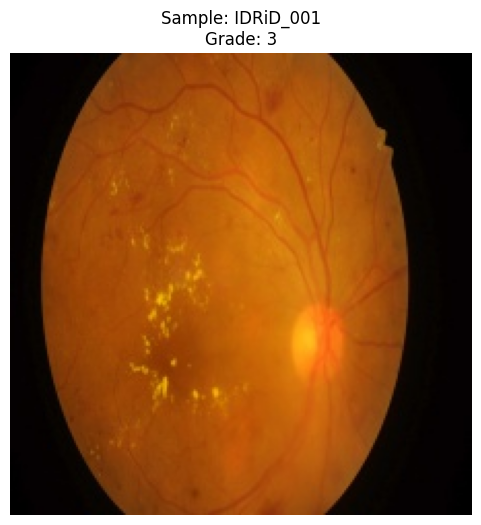

In [10]:
# TODO 2: Load data
# train_df = pd.read_csv('../../data/diabetic_retinopathy_images/groundtruths/training_labels.csv')
# print(train_df.head())

# TODO 2: Load data
train_labels_df = pd.read_csv('../../../datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv')
train_images_folder = '../../../datasets/diabetic_retinopathy_images/images/training_images_small'

print("Labels DataFrame:")
print(train_labels_df.head())
print(f"\nTotal training samples: {len(train_labels_df)}")
print(f"\nClass distribution:\n{train_labels_df['Retinopathy grade'].value_counts().sort_index()}")

# Load and display ONE sample image
sample_image_id = train_labels_df.iloc[0]['Image name'] 
sample_image_path = os.path.join(train_images_folder, f"{sample_image_id}.jpg")
sample_img = Image.open(sample_image_path)

print(f"\nSample image: {sample_image_id}")
print(f"Image size: {sample_img.size}")
print(f"Image mode: {sample_img.mode}")

plt.figure(figsize=(6, 6))
plt.imshow(sample_img)
plt.title(f"Sample: {sample_image_id}\nGrade: {train_labels_df.iloc[0]['Retinopathy grade']}")
plt.axis('off')
plt.show()


## 🎯 Class Mapping

### TODO 3: Document severity classes

**Expected:** Mapping from integer to severity level

**Class mapping:**

*Document your classes*

## 🤔 Reflection
1. Class balance?
2. Ethical concerns with DR screening?
3. Why this metric?

**Your reflection:**

### 1. Class Balance?

**Observation:** Severe class imbalance exists, especially for **Class 1 (Mild DR)**:
- Class 0 (No DR): 134 samples (32.4%) ✅
- **Class 1 (Mild): 20 samples (4.8%)** ⚠️ **SEVERELY UNDERREPRESENTED**
- Class 2 (Moderate): 136 samples (33.0%) ✅
- Class 3 (Severe): 74 samples (17.9%) ✅
- Class 4 (Proliferative): 49 samples (11.9%) ✅

**Imbalance Ratio:** Class 2 : Class 1 = 136:20 = **6.8:1**

**Why this is a problem:**
- Model will struggle to learn Class 1 (only 20 examples!)
- After 60/20/20 split: ~12 Class 1 samples in training set 😱
- Model may learn to **never predict Class 1** (easier to predict 0 or 2)
- This is **clinically dangerous**: Missing mild DR delays early treatment!

**Solutions I'll implement:**
1. **Stratified splitting** to preserve class ratios in train/val/test
2. **Class weights in loss function** (penalize wrong Class 1 predictions more)
3. **Data augmentation** for Class 1 (flips, rotations) to artificially increase samples
4. **Monitor per-class F1** (not just overall accuracy) to catch Class 1 failures
5. **Consider merging** Class 1 with Class 0 or 2 if performance is terrible

---

### 2. Ethical Concerns with DR Screening?

**Medical AI in ophthalmology raises several ethical issues:**

**A. Privacy & Data Security:**
- **Retinal images contain unique biometric patterns** → can identify individuals (like fingerprints!)
- **Risk:** If dataset is leaked, patients can be re-identified
- **PHI (Protected Health Information):** Images may contain metadata (patient ID, hospital, date)
- **Mitigation:** Anonymize data, secure storage, HIPAA/GDPR compliance

**B. Diagnostic Errors & Patient Harm:**
- **False Negatives (FN):** Model misses true DR cases → delayed treatment → vision loss
  - **Class 1 imbalance** makes this likely!
- **False Positives (FP):** Model over-diagnoses → unnecessary referrals, anxiety, healthcare costs
- **Who is responsible?** Doctor? AI developer? Hospital?
- **Mitigation:** Use AI as **screening tool only**, not diagnostic. Always require human ophthalmologist review.

**C. Algorithmic Bias:**
- **Dataset representation:** If training data lacks diversity (ethnicity, age, comorbidities), model may perform worse on underrepresented groups
- **Healthcare inequality:** Biased AI could worsen existing disparities (e.g., lower accuracy for minority patients)
- **This dataset (IDRiD):** 413 images from India. Will it generalize to other populations?
- **Mitigation:** Test on diverse populations, document limitations, monitor performance by demographic

**D. Informed Consent:**
- **Did patients consent** to their images being used for AI training?
- **Secondary use:** Images collected for clinical care, now used for research/commercial AI
- **Mitigation:** Institutional review board (IRB) approval, patient consent forms

**E. Clinical Deployment:**
- **Overreliance on AI:** Doctors may trust AI blindly and miss cases
- **Skill degradation:** Trainees may not learn manual DR grading if AI does it
- **Access inequality:** AI screening might only be available in wealthy hospitals
- **Mitigation:** AI as **decision support**, not replacement. Maintain human expertise.

**My Approach:**
- ✅ Acknowledge this is **educational only** (not for clinical use)
- ✅ Document model limitations transparently (class imbalance, small dataset)
- ✅ Emphasize **screening** (flagging high-risk cases for human review), not diagnosis
- ✅ Advocate for diverse, representative datasets in real deployments

---

### 3. Why This Metric?

**Question:** Why use **Weighted F1** or **Macro F1** instead of accuracy?

**Answer:**

**A. Accuracy is Misleading for Imbalanced Data:**

If I built a "dumb" model that **always predicts Class 0 or Class 2** (the two largest classes):
- **Accuracy:** (134 + 136) / 413 = **65.4%** (looks decent!)
- **But:** 0% accuracy on Classes 1, 3, 4 → **clinically useless!**

**Accuracy hides failures on minority classes.** This is **dangerous in healthcare!**

---

**B. F1 Score Balances Precision & Recall:**

**F1 = 2 × (Precision × Recall) / (Precision + Recall)**

- **Precision:** Of all DR cases I flagged, how many were actually DR? (avoid false alarms)
- **Recall:** Of all true DR cases, how many did I catch? (avoid missing patients)
- **F1:** Harmonic mean → penalizes models that sacrifice one for the other

**Example:**
- Model A: High precision (99%), low recall (20%) → flags only obvious cases, misses mild ones
- Model B: Low precision (50%), high recall (95%) → catches most cases but many false alarms
- **F1 forces balance** between these extremes!

---

**C. Macro F1 vs Weighted F1:**

**Macro F1:**
- **Definition:** Simple average of per-class F1 scores
- **Formula:** (F1_class0 + F1_class1 + ... + F1_class4) / 5
- **Treats all classes equally** (Class 1 with 20 samples = Class 2 with 136 samples)
- **Use when:** All classes are clinically important (catching mild DR matters as much as severe!)

**Weighted F1:**
- **Definition:** Weighted average of per-class F1, weighted by class support (number of samples)
- **Formula:** (F1_class0 × 134 + F1_class1 × 20 + ...) / 413
- **Gives more weight to larger classes**
- **Use when:** Some classes are more common/important in practice

**For this project:**

I'll use **both** and compare:
- **Macro F1:** Shows if model handles **all severities** well (including rare Class 1)
- **Weighted F1:** Shows **overall clinical performance** (how well does it work in practice, where Classes 0 and 2 dominate?)

**My goal:** Macro F1 ≥ 0.60 (all classes learned) AND Weighted F1 ≥ 0.70 (practical performance)

**Why not just accuracy?**
- Accuracy can be high while model fails on rare but clinically critical classes (Class 1, 4)
- F1 forces me to check **per-class performance** → ensures model works for all severity levels
- In healthcare AI, **equity across classes** (catching all disease severities) matters!

---

**Key Takeaway:** Metrics reflect values. Accuracy optimizes "overall correctness." F1 optimizes "balanced performance across all classes." For medical AI where **missing rare cases is dangerous**, F1 is the right metric! 🎯

**Your reflection:**

*Write here*

## 📌 Summary
✅ Problem defined  
✅ Dataset loaded  
✅ Metrics chosen

**Next:** `02_transforms_and_loaders.ipynb`